# Optimizing circuits for the Bernstein-Vazirani algorithm
The Bernstein-Vazirani algorithm is one of the first quantum algorithms. The implementation of the algorithm is based on a secret string $a$  which is used to compute the function 
$f(x)=ax \oplus b$. Assuming, that $b=0$ and that the strings $x$ and $a$ are $n$ bits wide, the value $f(x)$ is computed as $$f(x)=\sum a_i \cap x_i \,mod\, 2$$


## 1. Compilation

The function below compiles a circuit that takes the secret bitstring as a parameter and returns a Cirq Circuit, that allows to measure the secret in a single query.

In [58]:

from cirq import *

def bernstein_vazirani(secret: str) -> Circuit:
    """
    Implements the Bernstein-Vazirani algorithm using Cirq.
    
    Args:
        secret (str): A binary string representing the hidden bitstring.

    Returns:
        Circuit: A Cirq quantum circuit implementing the Bernstein-Vazirani algorithm.
    """

    # Determine the number of qubits based on the length of the secret string
    n = len(secret)
    
    qubits = LineQubit.range(n) # qubits is an array of `n` qubits for input
    ancilla = LineQubit(n)      # ancilla is an extra qubit for the oracle operation.
    
    circuit = Circuit()

    # Apply an X gate to the ancilla qubit to set it to |1>
    circuit.append(Moment(X(ancilla)))
    
    # Apply Hadamard gates to all qubits, including the ancilla, to create a uniform superposition
    ops_moment1 = [H(q) for q in qubits]
    ops_moment1.append(H(ancilla))
    circuit.append(Moment(ops_moment1))

    # Apply CNOT gates controlled by qubits where the secret bit is '1', flipping the ancilla if needed (oracle implementation)
    for i, bit in enumerate(secret):
        if bit == '1':
            circuit.append(Moment([CNOT(qubits[i], ancilla)]))
    
    # Apply a Hadamard gate to the ancilla qubit
    circuit.append(Moment(H(ancilla)))
    
    # Apply Hadamard gates to all input qubits to extract the secret bitstring
    circuit.append(Moment(H(q) for q in qubits))
    
    # Measure the qubits to read the secret string
    circuit.append(Moment(measure(*qubits, key='result')))
    
    return circuit

                      
s = '1011011'
bv_circuit = bernstein_vazirani(s)

simulator = Simulator()
result = simulator.run(bv_circuit)

print("Circuit:\n", bv_circuit)
print("\nResult of measurement:", result)

Circuit:
 0: ───────H───@───────────────────────H───M('result')───
              │                           │
1: ───────H───┼───────────────────────H───M─────────────
              │                           │
2: ───────H───┼───@───────────────────H───M─────────────
              │   │                       │
3: ───────H───┼───┼───@───────────────H───M─────────────
              │   │   │                   │
4: ───────H───┼───┼───┼───────────────H───M─────────────
              │   │   │                   │
5: ───────H───┼───┼───┼───@───────────H───M─────────────
              │   │   │   │               │
6: ───────H───┼───┼───┼───┼───@───────H───M─────────────
              │   │   │   │   │
7: ───X───H───X───X───X───X───X───H─────────────────────

Result of measurement: result=1, 0, 1, 1, 0, 1, 1


## 2. Optimization

Quantum cirquits can be optimized by applying various circuit identities. The identities used to optimize the Bernstein-Vazirani circuit are presented below.

Identity 1

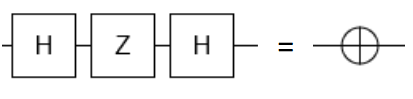


Identity 2

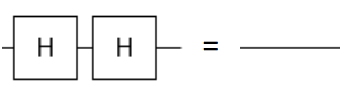

Identity 3

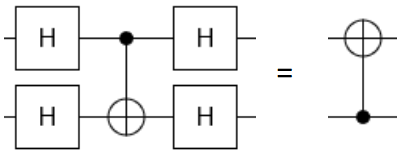

Identity 4

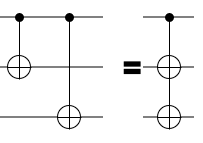

We now write a function that inputs a circuit from the `bernstein_vazirani()` function and returns an optimized version of it. For applying the last identity we need to additionally define a custom `SuperCNOT` gate since the basic Cirq `CNOT` supports merely one target.

In [59]:
class SuperCNOT(Gate):
    def __init__(self, c, t):
        """
        Create a SuperCNOT gate.
            :param control: The control qubit for the CNOT operations.
            :param targets: A list of target qubits for the CNOT operations.
        """
        self.control = c
        self.targets = t

    def num_qubits(self) -> int:
        return 1 + len(self.targets)

    def _decompose_(self, qubits):
        """
        Decompose the SuperCNOT into a series of standard CNOT gates.
            :param qubits: The control qubit and target qubits.
            :return: A sequence of operations that implements the SuperCNOT.
        """
        control = qubits[0]
        targets = qubits[1:]
        for target in targets:
            yield CNOT(control, target)

    def _circuit_diagram_info_(self, args):
        """Returns a custom string for circuit diagrams."""
        return ["@"] + ["X"] * len(self.targets)
    
    @property
    def qubits(self):
        return (self.control, self.targets)
    
    @property
    def name(self):
        target_indices = ','.join([str(target.x) for target in self.targets])
        return f"SuperCNOT(control={self.control.x}, targets=[{target_indices}])"
    


def optimize_bv(circuit: Circuit) -> Circuit:
    """
    Optimizes the Bernstein-Vazirani circuit by applying template/identity transformations.
    
    Args:
        circuit (Circuit): The input quantum circuit.
    
    Returns:
        Circuit: The optimized quantum circuit.
    """
    def apply_identity_1(circuit):
        """
        Applies the identity 1 transformation that was previously reversed.
        Converts the H-Z-H sequence back into a single X gate where applicable.
        """
        opt_bv = Circuit()
        H_qubits = []
        Z_qubits = []
        
        for moment in circuit:
            for operation in moment:
                q = operation.qubits[0]
                if q in H_qubits:
                    if q in Z_qubits:
                        if isinstance(operation.gate, type(H)):
                            opt_bv.append(X(q))
                        else:
                            opt_bv.append(H(q))
                            opt_bv.append(Z(q))
                        H_qubits.remove(q)
                        Z_qubits.remove(q)
                    elif isinstance(operation.gate, type(Z)):
                        Z_qubits.append(q)
                    else:
                        opt_bv.append(H(q))
                        H_qubits.remove(q)
                elif isinstance(operation.gate, type(H)):
                    H_qubits.append(q)
                else:
                    opt_bv.append(operation)
        # print('Circuit after identity 1:\n', opt_bv, '\n')
        return opt_bv

    def apply_identity_1_rev(circuit):
        """
        Reverses identity transformation 1 by converting X gates into H-Z-H sequences.
        This transformation makes it easier to apply further optimizations.
        """
        opt_bv = Circuit()
        for moment in circuit:
            for operation in moment:
                if isinstance(operation.gate, type(X)):  # If operation is an X gate
                    q = operation.qubits[0]
                    opt_bv.append(Moment(H(q)))
                    opt_bv.append(Moment(Z(q)))
                    opt_bv.append(Moment(H(q)))
                else:
                    opt_bv.append(operation)
        # print('Circuit after identity 1 reverse:\n', opt_bv, '\n')
        return opt_bv
                
    def apply_identity_2(circuit):
        """
        Removes redundant consecutive Hadamard gates.
        If a H gate is applied twice to the same qubit, it cancels out.
        """
        opt_bv = Circuit()
        firstH = []  # Tracks qubits that have received a Hadamard gate
        
        circuit_length = len(circuit)
        for i, moment in enumerate(circuit):
            for operation in moment:
                q = operation.qubits[0]
                if q in firstH:
                    if not isinstance(operation.gate, type(H)):
                        opt_bv.append(Moment(H(q)))
                        opt_bv.append(Moment(operation))
                    firstH.remove(q)
                else:
                    if isinstance(operation.gate, type(H)):
                        firstH.append(q)
                    else:
                        opt_bv.append(Moment(operation))
            if i == circuit_length - 2:
                opt_bv.append(Moment(H(qubit) for qubit in firstH))
                firstH = []
        # print('Circuit after identity 2:\n', opt_bv, '\n')
        return opt_bv
    
    def apply_template_3(circuit):
        """
        Reverses the order of CNOT gates by applying Hadamard transformations.
        Converts:
            CNOT(control, target) → H(control) H(target) CNOT(target, control) H(control) H(target)
        """
        opt_bv = Circuit()
        for moment in circuit:
            for operation in moment:
                if isinstance(operation.gate, type(CNOT)):  # If operation is a CNOT gate
                    control_q, target_q = operation.qubits
                    opt_bv.append(Moment(H(control_q), H(target_q)))
                    opt_bv.append(Moment(CNOT(target_q, control_q)))  # Reverse CNOT
                    opt_bv.append(Moment(H(control_q), H(target_q)))
                else:
                    opt_bv.append(operation)
        # print('Circuit after identity 3:\n', opt_bv, '\n')
        return opt_bv

    def apply_template_4(circuit):
        """
        Converts multiple CNOT gates with a common control qubit into a SuperCNOT gate.
        Ensures that SuperCNOT gates are inserted **before** measurement operations.
        """
        opt_bv = Circuit()
        common_control_q = None
        targets = []
        
        circuit_length = len(circuit)  # Track total number of moments

        for i, moment in enumerate(circuit):
            for operation in moment:
                if isinstance(operation.gate, type(CNOT)):
                    control_q, target_q = operation.qubits

                    # If the control qubit remains the same, accumulate targets
                    if control_q == common_control_q or common_control_q is None:
                        common_control_q = control_q
                        targets.append(target_q)
                    else:
                        # Insert the SuperCNOT **before** a measurement moment
                        super_cnot_gate = SuperCNOT(common_control_q, targets)
                        opt_bv.append(super_cnot_gate.on(common_control_q, *targets))
                        
                        # Reset tracking variables
                        common_control_q = control_q
                        targets = [target_q]
                else:
                    # Ensure that SuperCNOT is added **before** measurement
                    if common_control_q is not None:
                        super_cnot_gate = SuperCNOT(common_control_q, targets)
                        opt_bv.append(super_cnot_gate.on(common_control_q, *targets))
                        common_control_q = None
                        targets = []
                    
                    # Append the non-CNOT operation (e.g., measurement)
                    opt_bv.append(Moment(operation))
            
            # Before the last moment (typically measurements), ensure all pending SuperCNOTs are added
            if i == circuit_length - 2 and common_control_q is not None:
                super_cnot_gate = SuperCNOT(common_control_q, targets)
                opt_bv.append(super_cnot_gate.on(common_control_q, *targets))
                common_control_q = None
                targets = []
        # print('Circuit after identity 4:\n', opt_bv, '\n')
        return opt_bv

    # Apply transformations in sequence
    circuit = apply_identity_1_rev(circuit)
    circuit = apply_identity_2(circuit)
    circuit = apply_template_3(circuit)
    circuit = apply_identity_2(circuit)
    circuit = apply_template_4(circuit)
    circuit = apply_identity_1(circuit)

    return circuit

    
opt_circuit = optimize_bv(bv_circuit)


simulator = Simulator()
result = simulator.run(opt_circuit)

print("Circuit:\n", opt_circuit)
print("\nResult of measurement:", result)


Circuit:
 0: ───────X───M('result')───
          │   │
1: ───────┼───M─────────────
          │   │
2: ───────X───M─────────────
          │   │
3: ───────X───M─────────────
          │   │
4: ───────┼───M─────────────
          │   │
5: ───────X───M─────────────
          │   │
6: ───────X───M─────────────
          │
7: ───X───@─────────────────

Result of measurement: result=1, 0, 1, 1, 0, 1, 1


## 4. Benchmarking

We'll benchmark the runtimes of both the original circuit and the optimized circuit for various numbers of qubits. From the plot we see that the speed up becomes more and more significant with larger number of qubits.

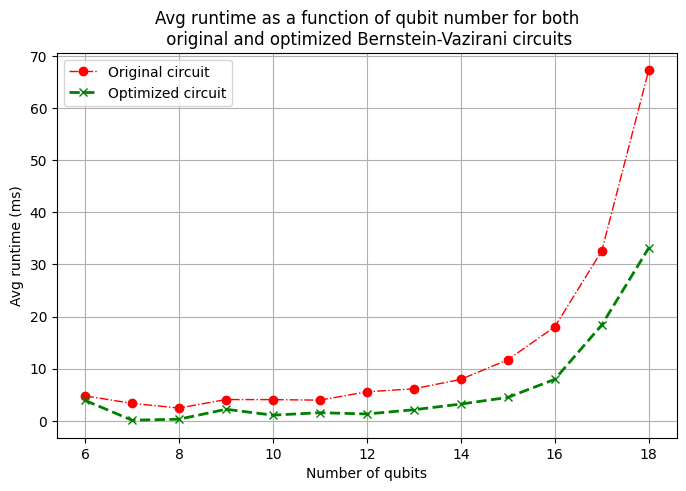

In [ ]:
import matplotlib.pyplot as plt
import time

def circuit_runtime(circuit):

    simulator = Simulator()
    start = time.time()
    result = simulator.run(circuit)
    end = time.time()
    runtime = end-start
    
    return runtime*1000 # s -> ms     

def centered_average(nums):
    if len(nums) < 3:
        return nums[0]

    return (sum(nums) - max(nums) - min(nums)) / (len(nums) - 2)

# Define the range of qubits to test (from 6 to 18 qubits)
qubits = range(6, 19)

# Initialize lists to store runtime results for original and optimized circuits
orig_bv_runtimes = []
opt_bv_runtimes = []

# Iterate over different numbers of qubits
for nr_q in qubits:
    # Create a secret bitstring of '1's for the Bernstein-Vazirani algorithm
    secret = '1' * nr_q

    # Generate the original and optimized BV circuits
    orig_bv = bernstein_vazirani(secret)
    opt_bv = optimize_bv(orig_bv)

    # Measure execution times for each circuit over 10 trials
    # Compute the centered average runtime to reduce noise from outliers
    orig_bv_runtimes.append(
        centered_average([circuit_runtime(orig_bv) for _ in range(10)])
    )
    opt_bv_runtimes.append(
        centered_average([circuit_runtime(opt_bv) for _ in range(10)])
    )


plt.figure(num = 3, figsize=(8, 5))
plt.plot(qubits, orig_bv_runtimes, 'o', color='red', linewidth=1.0, linestyle='-.', label='Original circuit')
plt.plot(qubits, opt_bv_runtimes, 'x', color='green', linewidth=2.0, linestyle='--', label='Optimized circuit')
plt.xlabel('Number of qubits')
plt.ylabel('Avg runtime (ms)')
plt.title('Avg runtime as a function of qubit number for both\n original and optimized Bernstein-Vazirani circuits')
plt.grid()
plt.legend()
plt.show()